# MNIST classification with CNN


In [1]:
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# make plt grayscale as default
plt.rcParams['image.cmap'] = 'gray'

DEV = 'cuda' # Use GPU # library for NVIDIA GPU
assert torch.cuda.is_available(), "Make sure you run this Colab in GPU"

## 0. Download Dataset

In [90]:
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor(), download=True)

torch.Size([1, 28, 28])


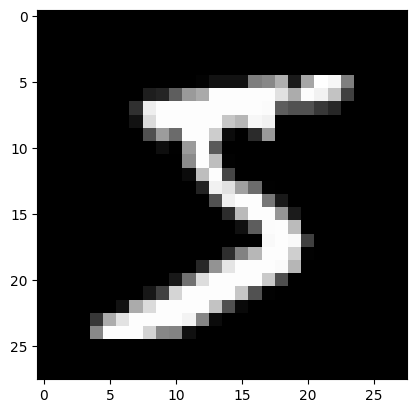

In [3]:
img, label = train_data[0]
print(img.shape)
plt.imshow(img.permute(1,2,0)) # img is in C x H x W -> so i converted to H x W x C

100

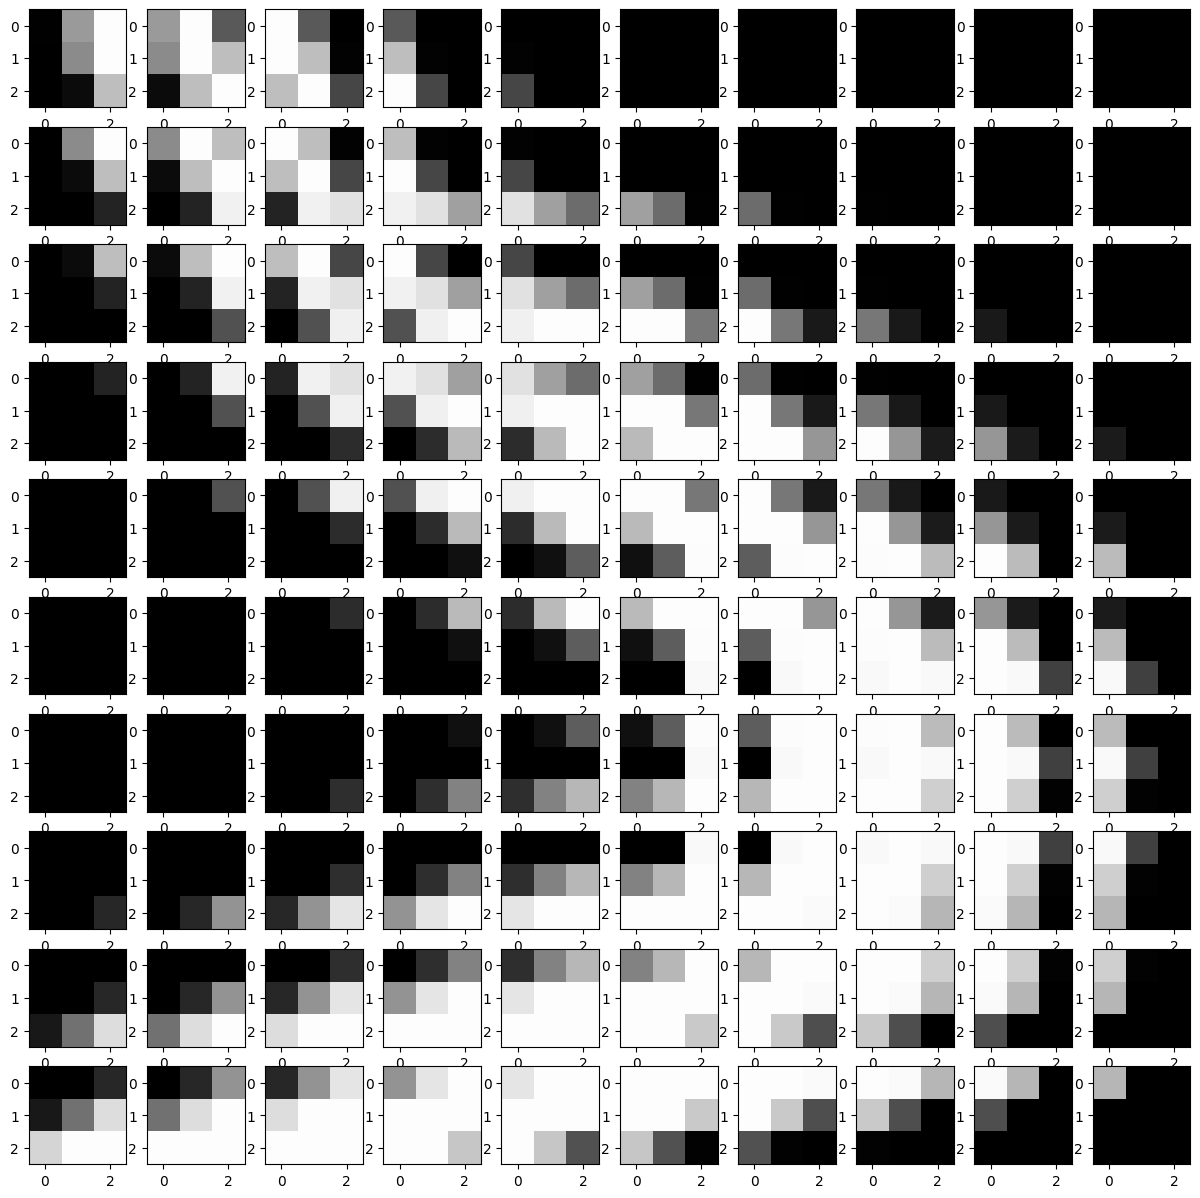

In [21]:
plt.figure(figsize=(15,15))

entire_sliced = []
for i in range(10, 20):
  for j in range(10, 20):
    sliced_img = img[:, i:i+3, j:j+3]
    entire_sliced.append(sliced_img)
    plt.subplot(10, 10, (i-10)*10+(j-10)+1)
    plt.imshow(sliced_img[0], vmin=0, vmax=1) # reduce channel axis
len(entire_sliced)

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [4]:
import torch.nn as nn
class CnnKernel(nn.Module):
  def __init__(self, output_ch=3, kernel_size=3):
    super().__init__()
    self.layer = nn.Linear(kernel_size*kernel_size*1, output_ch) # kernel_size is 3*3, input channel is 1
    self.kernel_size = kernel_size
    self.output_ch = output_ch

  def forward(self, x):
    # x: image tensor with shape of C x H x W
    channel, height, width = x.shape

    # output = []
    output_size = (self.output_ch, height - self.kernel_size +1, width - self.kernel_size + 1)
    output = torch.zeros(output_size)

    for i in range(height - self.kernel_size + 1):
      for j in range(width - self.kernel_size + 1):
        sliced_x = x[:, i:i+self.kernel_size, j:j+self.kernel_size]
        # flattened_x = sliced_x.flatten(1,2)
        flattened_x = sliced_x.reshape(channel, -1)
        sliced_out = self.layer(flattened_x)
        # output.append(sliced_out)
        output[:, i, j] = sliced_out
    return  output

kernel = CnnKernel()
# kernel.layer
# kernel.layer.weight.data = torch.Tensor([[1, 1, 1, 0, 0, 0, -1, -1, -1]])
out = kernel(img)
out.shape

torch.Size([3, 26, 26])

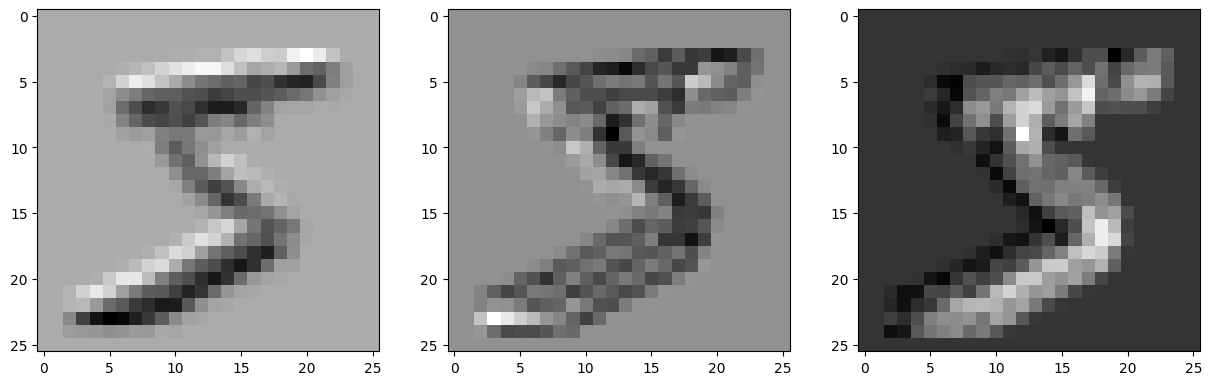

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(out[0].detach())
plt.subplot(1, 3, 2)
plt.imshow(out[1].detach())
plt.subplot(1, 3, 3)
plt.imshow(out[2].detach())

Output shape is torch.Size([16, 14, 14])


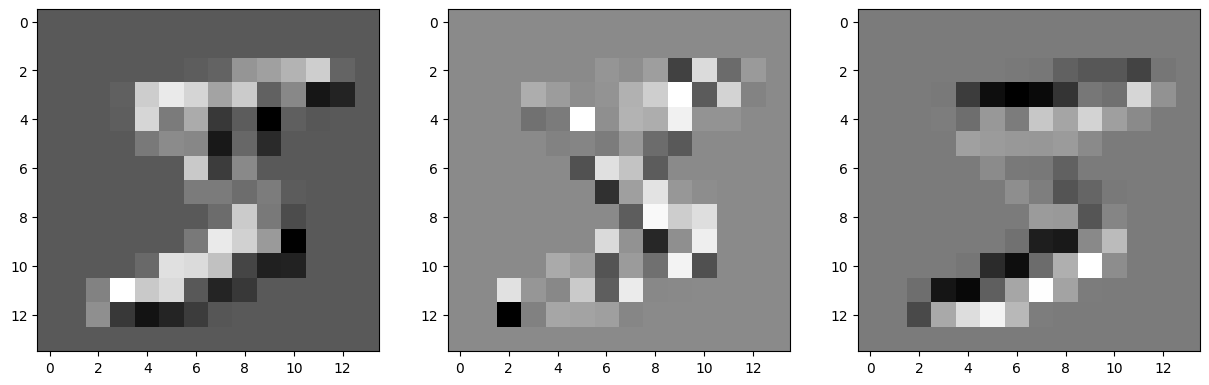

In [11]:
# instead of our custom CNN, we will use nn.Conv2d

conv_layer = nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=(3,3),
                       padding=1,
                       stride=2
                       )
out = conv_layer(img)
print(f"Output shape is {out.shape}")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(out[0].detach())
plt.subplot(1, 3, 2)
plt.imshow(out[1].detach())
plt.subplot(1, 3, 3)
plt.imshow(out[2].detach())

In [17]:
max_pool_layer = nn.MaxPool2d(2)

dummy= torch.randint(0, 50, (2,4,4))
dummy

tensor([[[ 9, 37, 41, 47],
         [44,  0, 24, 23],
         [12, 17,  3, 16],
         [10, 34, 41, 21]],

        [[41, 25,  3, 18],
         [ 9, 37,  8, 48],
         [12,  9,  5, 29],
         [ 5,  6, 18, 40]]])

In [18]:
pool_out = max_pool_layer(dummy)
pool_out

tensor([[[44, 47],
         [34, 41]],

        [[41, 48],
         [12, 40]]])

In [20]:
conv_layer = nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=(3,3),
                       padding=1,
                       stride=1
                       )

conv_pool = nn.Sequential(conv_layer,
                          nn.MaxPool2d(2))

out = conv_pool(img)
out.shape

torch.Size([16, 14, 14])

In [45]:
class Classifier(nn.Module):
  def __init__(self, channel_size=16, num_output_class=10):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(1, channel_size, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(channel_size, channel_size, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(channel_size, channel_size, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    # self.conv1 = nn.Conv2d(1, channel_size, kernel_size=3, padding=1)
    # self.relu = nn.ReLU()
    # self.pool = nn.MaxPool2d(2)
    # self.conv2 = nn.Conv2d(channel_size, channel_size, kernel_size=3, padding=1)
    # self.conv3 = nn.Conv2d(channel_size, channel_size, kernel_size=3)
    # self.last_pool = nn.MaxPool2d(5)
    self.proj_layer = nn.Linear(4 * channel_size, num_output_class)

  def forward(self, x):

    x = self.layers(x)
    x = x.flatten(-3)
    x = self.proj_layer(x)

    return x.softmax(dim=-1), x
    # print(x.shape)
    # x = self.conv1(x)
    # print(x.shape)
    # x = self.relu(x)
    # # print(x.shape)
    # x = self.pool(x)
    # print(x.shape)
    # x = self.conv2(x)
    # print(x.shape)
    # x = self.pool(x) # you can use same pooling layer again
    # print(x.shape)
    # x = self.relu(x) # order between relu and maxpool doesn't matter
    # x = self.conv3(x)
    # print(x.shape)
    # x = self.last_pool(x)
    # print(x.shape)
model = Classifier()
out = model(img)

In [39]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

batch = next(iter(train_loader))
imgs, labels = batch

In [40]:
out = model(imgs)

torch.Size([128, 10])

In [46]:
def train_one_step(model, optimizer, loss_function, input, target):
  pred, logit = model(input) # forward pass. compute the prediction
  # if loss_function == torch.nn.CrossEntropyLoss: # if loss_function is torch.nn.CrossEntropyLoss:
  if isinstance(loss_function, torch.nn.CrossEntropyLoss):
    loss = loss_function(logit, target)
  else:
    loss = loss_function(pred, target) # compute the loss
  loss.backward() # backpropagate theloss. compute the gradient
  optimizer.step() # update the parameters based on each gradient
  optimizer.zero_grad() # clear the gradient for every parameters
  return loss.item() # return the loss value

cross_entropy_fn = torch.nn.CrossEntropyLoss()

model = Classifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_one_step(model, optimizer, cross_entropy_fn, imgs, labels)


2.316507339477539

In [107]:
import time
from tqdm.auto import tqdm

model = Classifier(16)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
num_epochs = 4
DEV = 'cuda'
model.to(DEV) # move model to cuda. Move model's parameter on GPU's VRAM

for epoch in tqdm(range(num_epochs)):
  for batch in tqdm(train_loader, leave=False):
    imgs, labels = batch
    imgs = imgs.to(DEV)  # Movetensor to GPU's VRAM
    labels = labels.to(DEV)
    loss = train_one_step(model, optimizer, cross_entropy_fn, imgs, labels)
    losses.append(loss)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [76]:
class MLPClassifier(nn.Module):
  def __init__(self, hidden_dim, input_dim=784, out_dim=10):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim)
    )

  def forward(self, x:torch.Tensor):
    logit = self.layers(x)
    prob = logit.softmax(dim=-1)

    return prob, logit


mlp_model = Classifier(32)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_losses = []
num_epochs = 5
DEV = 'cuda'
mlp_model.to(DEV) # move model to cuda. Move model's parameter on GPU's VRAM

for epoch in tqdm(range(num_epochs)):
  for batch in tqdm(train_loader, leave=False):
    imgs, labels = batch
    imgs = imgs.to(DEV)  # Movetensor to GPU's VRAM
    labels = labels.to(DEV)
    loss = train_one_step(mlp_model, mlp_optimizer, cross_entropy_fn, imgs, labels)
    mlp_losses.append(loss)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

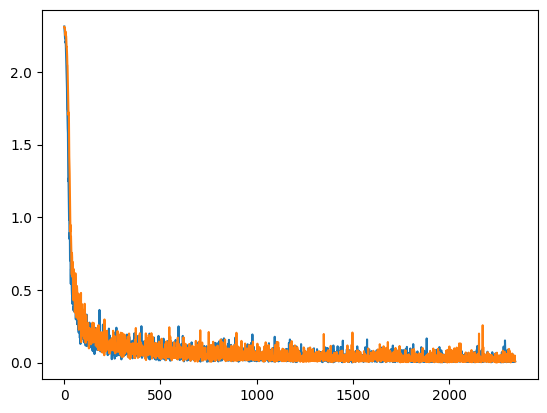

In [49]:
plt.plot(losses)
plt.plot(mlp_losses)

In [108]:
def get_accuracy(pred, labels):
  predicted_class = torch.argmax(pred, dim=-1)
  is_true = predicted_class.to(labels.device) == labels # because it is boolean, it's better to
  acc = (is_true.sum() / is_true.numel()).item()
  return acc


valid_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

valid_acc_sum = 0
with torch.inference_mode(): # Code below this line does not calculate gradient
  for batch in valid_loader:
    imgs, labels = batch
    imgs = imgs.to(DEV)  # Movetensor to GPU's VRAM
    labels = labels.to(DEV)
    pred, logit = model(imgs)
    acc = get_accuracy(pred, labels)
    valid_acc_sum += acc
valid_acc = valid_acc_sum / len(valid_loader) # number of total batch
print(valid_acc)

0.981699977517128


In [111]:
valid_acc_sum = 0
with torch.inference_mode(): # Code below this line does not calculate gradient
  for batch in valid_loader:
    imgs, labels = batch
    imgs = imgs.to(DEV)  # Move tensor to GPU's VRAM
    labels = labels.to(DEV)
    shifted_imgs = shift_img(imgs, num_shift=2)
    pred, logit = model(shifted_imgs)
    acc = get_accuracy(pred, labels)
    valid_acc_sum += acc
valid_acc = valid_acc_sum / len(valid_loader) # number of total batch
print(valid_acc)

0.8514999830722809


In [109]:
model

Classifier(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (proj_layer): Linear(in_features=64, out_features=10, bias=True)
)

In [54]:
imgs.shape

torch.Size([100, 1, 28, 28])

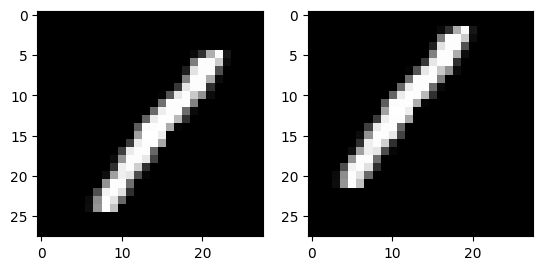

In [106]:
num_shift = 3
shifted_imgs = torch.zeros_like(imgs)
shifted_imgs[:, :, num_shift:, num_shift:] = imgs[:,:,:-num_shift, :-num_shift]

def shift_img(imgs, num_shift):
  shifted_imgs = torch.zeros_like(imgs)
  shifted_imgs[:, :, :-num_shift, :-num_shift] = imgs[:,:,num_shift:, num_shift:].clone()
  return shifted_imgs

shifted_imgs = shift_img(imgs, 3)
idx = 3
plt.subplot(1,2,1)
plt.imshow(imgs[idx, 0].detach().cpu())
plt.subplot(1,2,2)
plt.imshow(shifted_imgs[idx, 0].detach().cpu())